# Testing the models

Let's evaluate our models on the test set.
We are going to analyze accuracy, the confusion matrix, a complete classification report and the ROC curve.
Last but not least, we are going to present some of the top confident failures of the model to discuss them.  

#### Import dependencies and the test dataset Pascal VOC 2012

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

from torch.utils.data import Dataset
from PIL import Image
import os
import random
from torchvision import transforms

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc

from sklearn.preprocessing import label_binarize
from torch.nn.functional import softmax

import torch
from torchvision import models
import torch.nn as nn
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import seaborn as sns

# Paths to VOC directories
base_dir = '/kaggle/input/pascal-voc-2012-dataset/VOC2012_test/VOC2012_test'
images_dir = os.path.join(base_dir, 'JPEGImages')
sets_dir = os.path.join(base_dir, 'ImageSets/Main')


## Define the dataset 
We define some functions to augment data to make them fit for our SSL image-orientation pretext task 

In [3]:
# Function to read predefined splits
def get_files_from_split(file_path):
    with open(file_path, 'r') as f:
        files = [x.strip().split()[0] for x in f.readlines() if not x.startswith('#')]
    return files

class RotationDataset(Dataset):
    def __init__(self, file_list, root_dir, transform=None):
        """
        file_list: lista dei nomi dei file (es. ['2008_000001', ...])
        root_dir: cartella dove sono le immagini JPEG
        """
        self.file_list = file_list
        self.root_dir = root_dir
        self.transform = transform
        
        # Mappa le rotazioni in classi
        self.angle_to_label = {0: 0, 90: 1, 180: 2, 270: 3}

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        filename = self.file_list[idx]
        img_path = os.path.join(self.root_dir, filename + ".jpg")
        
        image = Image.open(img_path).convert("RGB")
        
        # 1. Scegliamo una rotazione casuale
        angle = random.choice([0, 90, 180, 270])
        
        # 2. Ruotiamo l'immagine
        # Nota: expand=True adatta la dimensione se l'img non è quadrata
        rotated_image = image.rotate(-angle, expand=True) 
        
        # 3. Creiamo la label per la rotazione
        label_rotation = self.angle_to_label[angle]
        
        # 4. Applichiamo le trasformazioni standard (Resize, ToTensor, Normalize)
        if self.transform:
            rotated_image = self.transform(rotated_image)
            
        return rotated_image, label_rotation

# Esempio di utilizzo
transform_pipeline = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [4]:
# Get all files from test.txt
test_files = get_files_from_split(os.path.join(sets_dir, 'test.txt'))
np.random.shuffle(test_files)  # Shuffle to randomize the split

test_dataset = RotationDataset(test_files, images_dir, transform=transform_pipeline)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

test_loader = DataLoader(
    test_dataset,
    batch_size=128,
    shuffle=False
)

## The evaluation function

In [5]:
def evaluate_model(model, test_loader, class_names):

    y_preds = []
    y_labels = []
    y_probs = []

    misclassified_examples = []

    model.eval()
    with torch.no_grad():
        for x, y in test_loader:
            x = x.to(device)
            y = y.to(device)

            outputs = model(x)
            probs = softmax(outputs, dim=1)
            confs, preds = torch.max(probs, dim=1)

            # Store predictions
            y_preds.extend(preds.cpu().numpy())
            y_labels.extend(y.cpu().numpy())
            y_probs.extend(probs.cpu().numpy())

            # Store confident misclassifications
            for i in range(len(y)):
                if preds[i] != y[i]:
                    misclassified_examples.append({
                        "img": x[i].cpu(),
                        "true": y[i].item(),
                        "pred": preds[i].item(),
                        "conf": confs[i].item()
                    })

    # ---------------- Accuracy ----------------
    acc = accuracy_score(y_labels, y_preds)
    print(f"\nTest Accuracy: {acc:.4f}")

    # ---------------- Confusion Matrix ----------------
    cm = confusion_matrix(y_labels, y_preds)
    plt.figure(figsize=(6, 5))
    sns.heatmap(
        cm, annot=True, fmt='d', cmap='Blues',
        xticklabels=class_names,
        yticklabels=class_names
    )
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

    # ---------------- Classification Report ----------------
    print("\nCLASSIFICATION REPORT")
    print(classification_report(
        y_labels,
        y_preds,
        target_names=class_names,
        digits=4
    ))

    # ---------------- ROC CURVES (One-vs-Rest) ----------------
    print("\nROC CURVES")

    num_classes = len(class_names)
    y_labels_bin = label_binarize(y_labels, classes=list(range(num_classes)))
    y_probs = np.array(y_probs)

    plt.figure(figsize=(7, 6))

    for i in range(num_classes):
        fpr, tpr, _ = roc_curve(y_labels_bin[:, i], y_probs[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{class_names[i]} (AUC = {roc_auc:.3f})")

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curves (One-vs-Rest)")
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)
    plt.show()

    # ---------------- TOP CONFIDENT FAILURES ----------------
    print("\n3. TOP CONFIDENT FAILURES (Visual Inspection)")
    print("These are images where the model was very confident but WRONG.")

    misclassified_examples.sort(key=lambda x: x["conf"], reverse=True)

    num_show = min(5, len(misclassified_examples))

    if num_show > 0:
        fig, axes = plt.subplots(1, num_show, figsize=(15, 4))
        if num_show == 1:
            axes = [axes]

        for i in range(num_show):
            data = misclassified_examples[i]

            # Un-normalize (ImageNet)
            img = data["img"].clone()
            mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
            std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
            img = img * std + mean
            img = torch.clamp(img, 0, 1)

            ax = axes[i]
            ax.imshow(img.permute(1, 2, 0).numpy())
            ax.axis("off")
            ax.set_title(
                f"True: {class_names[data['true']]}\n"
                f"Pred: {class_names[data['pred']]}\n"
                f"Conf: {data['conf']:.2f}",
                color="red",
                fontsize=10
            )

        plt.show()
    else:
        print("No errors found! (100% Accuracy)")

In [6]:
# Define class names (based on your rotation angles)
class_names = ['0°', '90°', '180°', '270°']

# Evaluation
## SimpleCNN full training

In [7]:
import torch.nn as nn

# Model definition: SimpleCNN
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=4):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),
            
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),
            
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        self.gap = nn.AdaptiveAvgPool2d(1)

        self.classifier = nn.Sequential(
            nn.Linear(256, 128),
            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.gap(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


Test Accuracy: 0.5110


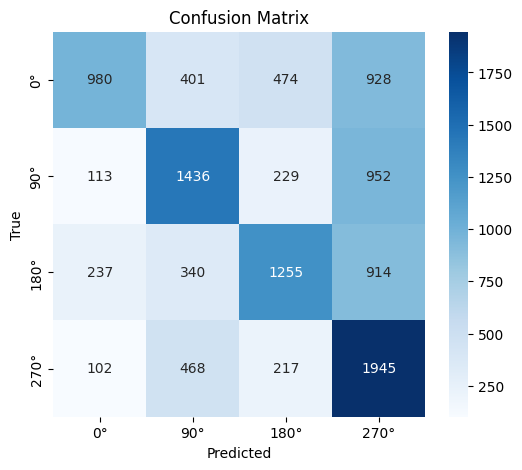


CLASSIFICATION REPORT
              precision    recall  f1-score   support

          0°     0.6844    0.3521    0.4650      2783
         90°     0.5429    0.5260    0.5343      2730
        180°     0.5770    0.4570    0.5101      2746
        270°     0.4104    0.7119    0.5207      2732

    accuracy                         0.5110     10991
   macro avg     0.5537    0.5118    0.5075     10991
weighted avg     0.5543    0.5110    0.5073     10991


ROC CURVES


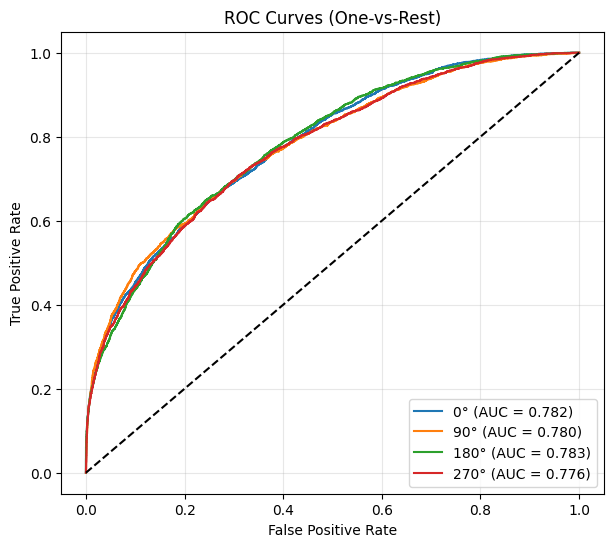


3. TOP CONFIDENT FAILURES (Visual Inspection)
These are images where the model was very confident but WRONG.


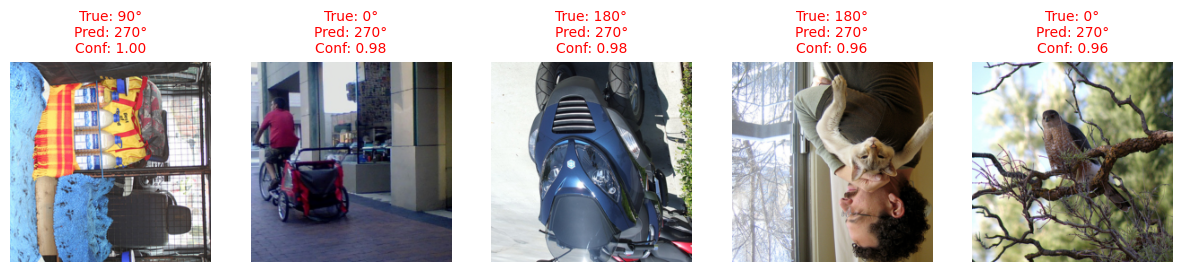

In [8]:
model = SimpleCNN(num_classes=4)

model.load_state_dict(torch.load("/kaggle/input/simplecnn-nocrop/pytorch/default/1/SimpleRotationCNN224_nocropmix.pth", map_location=device))
model.to(device)

evaluate_model(model, test_loader, class_names)

## Simple CNN full training with CropMix


Test Accuracy: 0.7952


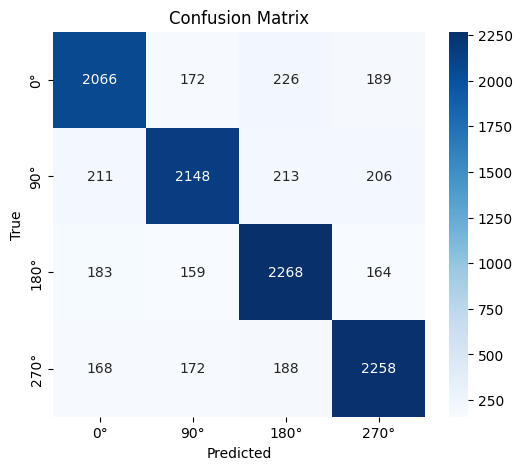


CLASSIFICATION REPORT
              precision    recall  f1-score   support

          0°     0.7861    0.7787    0.7824      2653
         90°     0.8103    0.7732    0.7913      2778
        180°     0.7834    0.8176    0.8001      2774
        270°     0.8016    0.8105    0.8060      2786

    accuracy                         0.7952     10991
   macro avg     0.7953    0.7950    0.7950     10991
weighted avg     0.7955    0.7952    0.7951     10991


ROC CURVES


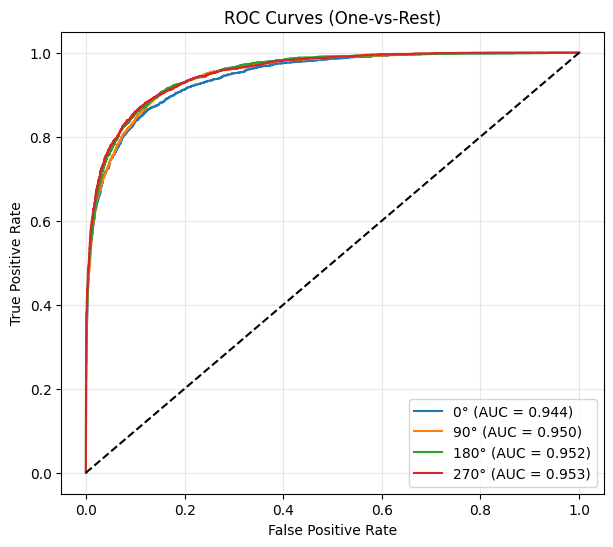


3. TOP CONFIDENT FAILURES (Visual Inspection)
These are images where the model was very confident but WRONG.


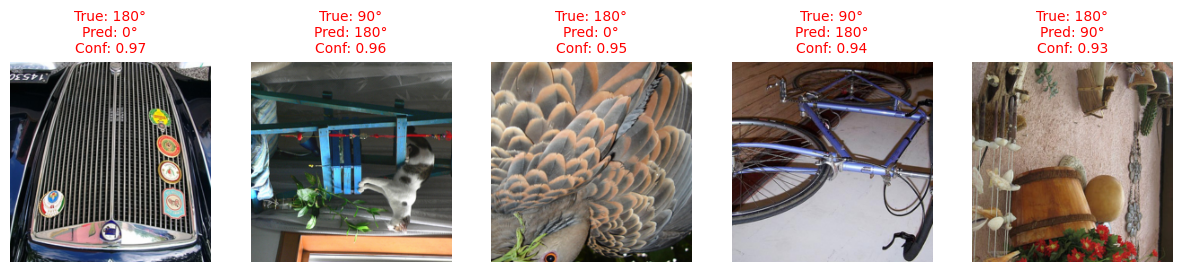

In [9]:
model = SimpleCNN(num_classes=4)

model.load_state_dict(torch.load("/kaggle/input/simplecnn-fulltraining/pytorch/default/1/SimpleRotationCNN.pth", map_location=device))
model.to(device)

evaluate_model(model, test_loader, class_names)

## ResNet18 full training 


Test Accuracy: 0.8359


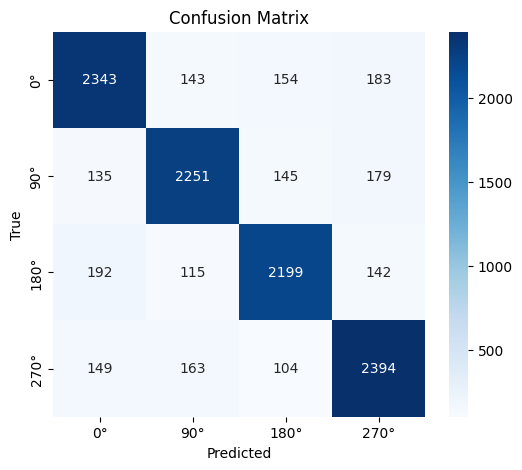


CLASSIFICATION REPORT
              precision    recall  f1-score   support

          0°     0.8311    0.8300    0.8306      2823
         90°     0.8424    0.8306    0.8365      2710
        180°     0.8451    0.8304    0.8377      2648
        270°     0.8261    0.8520    0.8388      2810

    accuracy                         0.8359     10991
   macro avg     0.8362    0.8357    0.8359     10991
weighted avg     0.8360    0.8359    0.8359     10991


ROC CURVES


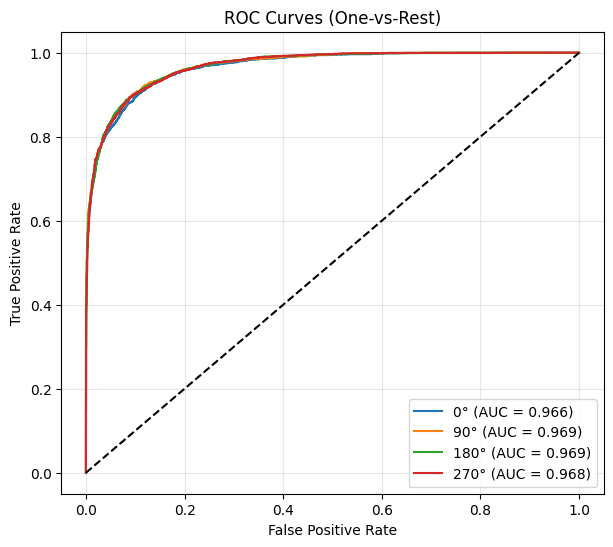


3. TOP CONFIDENT FAILURES (Visual Inspection)
These are images where the model was very confident but WRONG.


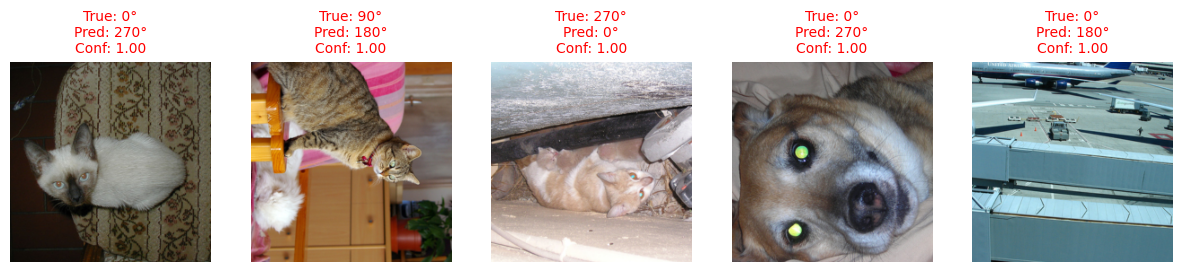

In [10]:
model = models.resnet18(weights = None)

# Modifichiamo l'ultimo layer (Fully Connected) per avere 4 output (0, 90, 180, 270)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 4)

model.load_state_dict(torch.load("/kaggle/input/resnet18-fulltraining-nocrop/pytorch/default/1/fullTraining_ResNet18_nocropmix.pth", map_location=device))
model.to(device)

evaluate_model(model, test_loader, class_names)

## ResNet18 full training with CropMix


Test Accuracy: 0.7229


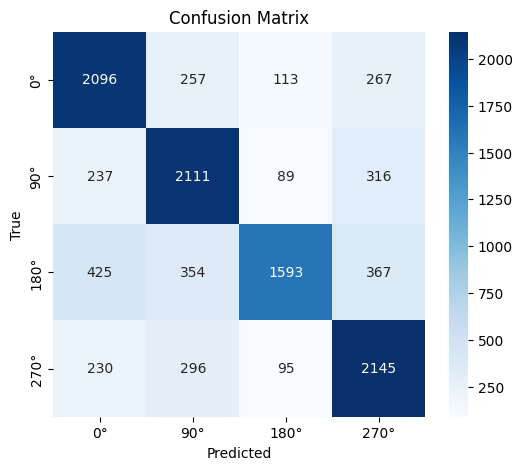


CLASSIFICATION REPORT
              precision    recall  f1-score   support

          0°     0.7015    0.7669    0.7327      2733
         90°     0.6995    0.7668    0.7316      2753
        180°     0.8429    0.5816    0.6883      2739
        270°     0.6931    0.7755    0.7320      2766

    accuracy                         0.7229     10991
   macro avg     0.7342    0.7227    0.7211     10991
weighted avg     0.7341    0.7229    0.7212     10991


ROC CURVES


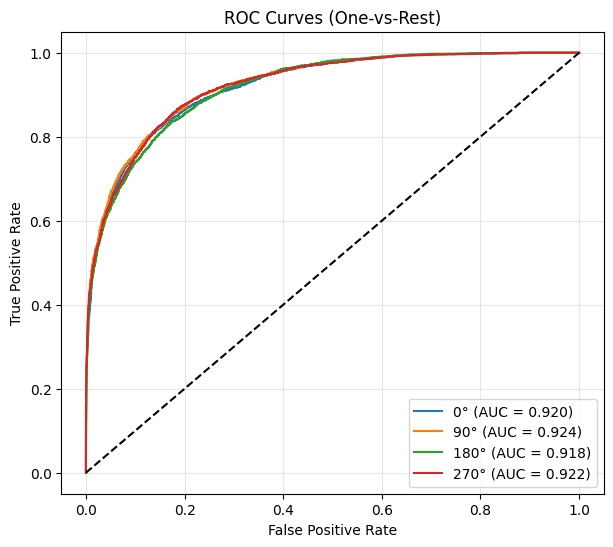


3. TOP CONFIDENT FAILURES (Visual Inspection)
These are images where the model was very confident but WRONG.


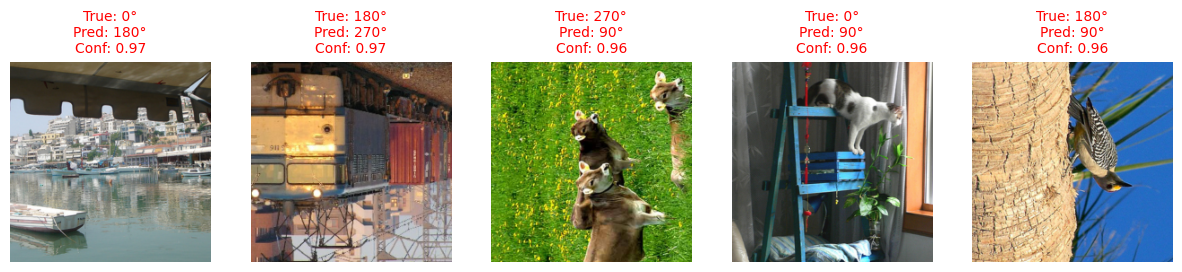

In [12]:
model = models.resnet18(weights = None)

# Modifichiamo l'ultimo layer (Fully Connected) per avere 4 output (0, 90, 180, 270)
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(num_ftrs, num_ftrs),  # Hidden layer (maintains size or reduces)
    nn.ReLU(),                      # Non-linearity (Crucial!)
    nn.Linear(num_ftrs, 4)          # Output layer
)

model.load_state_dict(torch.load("/kaggle/input/resnet18-fulltraining/pytorch/default/1/fullTraining_ResNet18.pth", map_location=device))
model.to(device)

evaluate_model(model, test_loader, class_names)

## ResNet18 fine-tuning

In [13]:
model = models.resnet18(weights=None)

# Modifichiamo l'ultimo layer (Fully Connected) per avere 4 output (0, 90, 180, 270)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 4) 

model.load_state_dict(torch.load("/kaggle/input/resnet18-finetuning/pytorch/default/1/fineTuning_ResNet18.pth", map_location=device))
model.to(device)

evaluate_model(model, test_loader, class_names)

RuntimeError: Error(s) in loading state_dict for ResNet:
	Missing key(s) in state_dict: "conv1.weight", "bn1.weight", "bn1.bias", "bn1.running_mean", "bn1.running_var", "layer1.0.conv1.weight", "layer1.0.bn1.weight", "layer1.0.bn1.bias", "layer1.0.bn1.running_mean", "layer1.0.bn1.running_var", "layer1.0.conv2.weight", "layer1.0.bn2.weight", "layer1.0.bn2.bias", "layer1.0.bn2.running_mean", "layer1.0.bn2.running_var", "layer1.1.conv1.weight", "layer1.1.bn1.weight", "layer1.1.bn1.bias", "layer1.1.bn1.running_mean", "layer1.1.bn1.running_var", "layer1.1.conv2.weight", "layer1.1.bn2.weight", "layer1.1.bn2.bias", "layer1.1.bn2.running_mean", "layer1.1.bn2.running_var", "layer2.0.conv1.weight", "layer2.0.bn1.weight", "layer2.0.bn1.bias", "layer2.0.bn1.running_mean", "layer2.0.bn1.running_var", "layer2.0.conv2.weight", "layer2.0.bn2.weight", "layer2.0.bn2.bias", "layer2.0.bn2.running_mean", "layer2.0.bn2.running_var", "layer2.0.downsample.0.weight", "layer2.0.downsample.1.weight", "layer2.0.downsample.1.bias", "layer2.0.downsample.1.running_mean", "layer2.0.downsample.1.running_var", "layer2.1.conv1.weight", "layer2.1.bn1.weight", "layer2.1.bn1.bias", "layer2.1.bn1.running_mean", "layer2.1.bn1.running_var", "layer2.1.conv2.weight", "layer2.1.bn2.weight", "layer2.1.bn2.bias", "layer2.1.bn2.running_mean", "layer2.1.bn2.running_var", "layer3.0.conv1.weight", "layer3.0.bn1.weight", "layer3.0.bn1.bias", "layer3.0.bn1.running_mean", "layer3.0.bn1.running_var", "layer3.0.conv2.weight", "layer3.0.bn2.weight", "layer3.0.bn2.bias", "layer3.0.bn2.running_mean", "layer3.0.bn2.running_var", "layer3.0.downsample.0.weight", "layer3.0.downsample.1.weight", "layer3.0.downsample.1.bias", "layer3.0.downsample.1.running_mean", "layer3.0.downsample.1.running_var", "layer3.1.conv1.weight", "layer3.1.bn1.weight", "layer3.1.bn1.bias", "layer3.1.bn1.running_mean", "layer3.1.bn1.running_var", "layer3.1.conv2.weight", "layer3.1.bn2.weight", "layer3.1.bn2.bias", "layer3.1.bn2.running_mean", "layer3.1.bn2.running_var", "layer4.0.conv1.weight", "layer4.0.bn1.weight", "layer4.0.bn1.bias", "layer4.0.bn1.running_mean", "layer4.0.bn1.running_var", "layer4.0.conv2.weight", "layer4.0.bn2.weight", "layer4.0.bn2.bias", "layer4.0.bn2.running_mean", "layer4.0.bn2.running_var", "layer4.0.downsample.0.weight", "layer4.0.downsample.1.weight", "layer4.0.downsample.1.bias", "layer4.0.downsample.1.running_mean", "layer4.0.downsample.1.running_var", "layer4.1.conv1.weight", "layer4.1.bn1.weight", "layer4.1.bn1.bias", "layer4.1.bn1.running_mean", "layer4.1.bn1.running_var", "layer4.1.conv2.weight", "layer4.1.bn2.weight", "layer4.1.bn2.bias", "layer4.1.bn2.running_mean", "layer4.1.bn2.running_var", "fc.weight", "fc.bias". 
	Unexpected key(s) in state_dict: "module.conv1.weight", "module.bn1.weight", "module.bn1.bias", "module.bn1.running_mean", "module.bn1.running_var", "module.bn1.num_batches_tracked", "module.layer1.0.conv1.weight", "module.layer1.0.bn1.weight", "module.layer1.0.bn1.bias", "module.layer1.0.bn1.running_mean", "module.layer1.0.bn1.running_var", "module.layer1.0.bn1.num_batches_tracked", "module.layer1.0.conv2.weight", "module.layer1.0.bn2.weight", "module.layer1.0.bn2.bias", "module.layer1.0.bn2.running_mean", "module.layer1.0.bn2.running_var", "module.layer1.0.bn2.num_batches_tracked", "module.layer1.1.conv1.weight", "module.layer1.1.bn1.weight", "module.layer1.1.bn1.bias", "module.layer1.1.bn1.running_mean", "module.layer1.1.bn1.running_var", "module.layer1.1.bn1.num_batches_tracked", "module.layer1.1.conv2.weight", "module.layer1.1.bn2.weight", "module.layer1.1.bn2.bias", "module.layer1.1.bn2.running_mean", "module.layer1.1.bn2.running_var", "module.layer1.1.bn2.num_batches_tracked", "module.layer2.0.conv1.weight", "module.layer2.0.bn1.weight", "module.layer2.0.bn1.bias", "module.layer2.0.bn1.running_mean", "module.layer2.0.bn1.running_var", "module.layer2.0.bn1.num_batches_tracked", "module.layer2.0.conv2.weight", "module.layer2.0.bn2.weight", "module.layer2.0.bn2.bias", "module.layer2.0.bn2.running_mean", "module.layer2.0.bn2.running_var", "module.layer2.0.bn2.num_batches_tracked", "module.layer2.0.downsample.0.weight", "module.layer2.0.downsample.1.weight", "module.layer2.0.downsample.1.bias", "module.layer2.0.downsample.1.running_mean", "module.layer2.0.downsample.1.running_var", "module.layer2.0.downsample.1.num_batches_tracked", "module.layer2.1.conv1.weight", "module.layer2.1.bn1.weight", "module.layer2.1.bn1.bias", "module.layer2.1.bn1.running_mean", "module.layer2.1.bn1.running_var", "module.layer2.1.bn1.num_batches_tracked", "module.layer2.1.conv2.weight", "module.layer2.1.bn2.weight", "module.layer2.1.bn2.bias", "module.layer2.1.bn2.running_mean", "module.layer2.1.bn2.running_var", "module.layer2.1.bn2.num_batches_tracked", "module.layer3.0.conv1.weight", "module.layer3.0.bn1.weight", "module.layer3.0.bn1.bias", "module.layer3.0.bn1.running_mean", "module.layer3.0.bn1.running_var", "module.layer3.0.bn1.num_batches_tracked", "module.layer3.0.conv2.weight", "module.layer3.0.bn2.weight", "module.layer3.0.bn2.bias", "module.layer3.0.bn2.running_mean", "module.layer3.0.bn2.running_var", "module.layer3.0.bn2.num_batches_tracked", "module.layer3.0.downsample.0.weight", "module.layer3.0.downsample.1.weight", "module.layer3.0.downsample.1.bias", "module.layer3.0.downsample.1.running_mean", "module.layer3.0.downsample.1.running_var", "module.layer3.0.downsample.1.num_batches_tracked", "module.layer3.1.conv1.weight", "module.layer3.1.bn1.weight", "module.layer3.1.bn1.bias", "module.layer3.1.bn1.running_mean", "module.layer3.1.bn1.running_var", "module.layer3.1.bn1.num_batches_tracked", "module.layer3.1.conv2.weight", "module.layer3.1.bn2.weight", "module.layer3.1.bn2.bias", "module.layer3.1.bn2.running_mean", "module.layer3.1.bn2.running_var", "module.layer3.1.bn2.num_batches_tracked", "module.layer4.0.conv1.weight", "module.layer4.0.bn1.weight", "module.layer4.0.bn1.bias", "module.layer4.0.bn1.running_mean", "module.layer4.0.bn1.running_var", "module.layer4.0.bn1.num_batches_tracked", "module.layer4.0.conv2.weight", "module.layer4.0.bn2.weight", "module.layer4.0.bn2.bias", "module.layer4.0.bn2.running_mean", "module.layer4.0.bn2.running_var", "module.layer4.0.bn2.num_batches_tracked", "module.layer4.0.downsample.0.weight", "module.layer4.0.downsample.1.weight", "module.layer4.0.downsample.1.bias", "module.layer4.0.downsample.1.running_mean", "module.layer4.0.downsample.1.running_var", "module.layer4.0.downsample.1.num_batches_tracked", "module.layer4.1.conv1.weight", "module.layer4.1.bn1.weight", "module.layer4.1.bn1.bias", "module.layer4.1.bn1.running_mean", "module.layer4.1.bn1.running_var", "module.layer4.1.bn1.num_batches_tracked", "module.layer4.1.conv2.weight", "module.layer4.1.bn2.weight", "module.layer4.1.bn2.bias", "module.layer4.1.bn2.running_mean", "module.layer4.1.bn2.running_var", "module.layer4.1.bn2.num_batches_tracked", "module.fc.weight", "module.fc.bias". 

## ResNet50 full training 


Test Accuracy: 0.6950


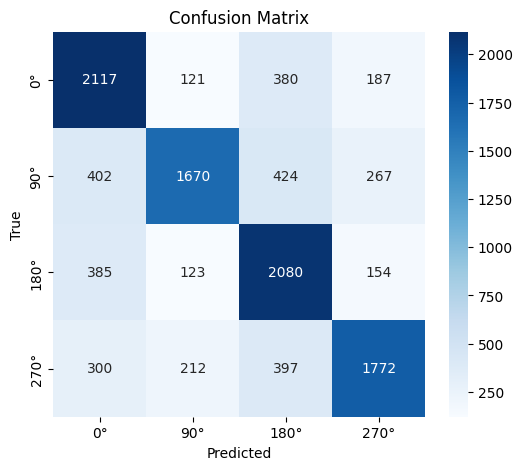


CLASSIFICATION REPORT
              precision    recall  f1-score   support

          0°     0.6607    0.7547    0.7046      2805
         90°     0.7855    0.6044    0.6832      2763
        180°     0.6340    0.7586    0.6907      2742
        270°     0.7445    0.6609    0.7003      2681

    accuracy                         0.6950     10991
   macro avg     0.7062    0.6947    0.6947     10991
weighted avg     0.7059    0.6950    0.6947     10991


ROC CURVES


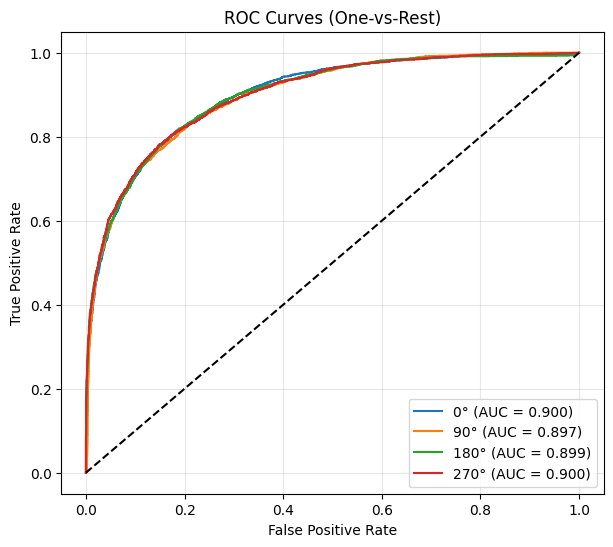


3. TOP CONFIDENT FAILURES (Visual Inspection)
These are images where the model was very confident but WRONG.


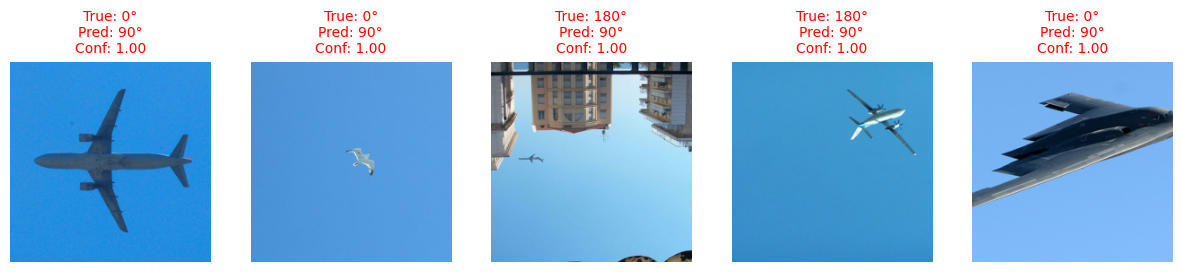

In [14]:
model = models.resnet50(weights = None)

# Modifichiamo l'ultimo layer (Fully Connected) per avere 4 output (0, 90, 180, 270)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 4) 

model.load_state_dict(torch.load("/kaggle/input/resnet50-fulltraining-nocrop/pytorch/default/1/fullTraining_ResNet50_nocropmix.pth", map_location=device))
model.to(device)

evaluate_model(model, test_loader, class_names)

## ResNet50 full training with CropMix


Test Accuracy: 0.7992


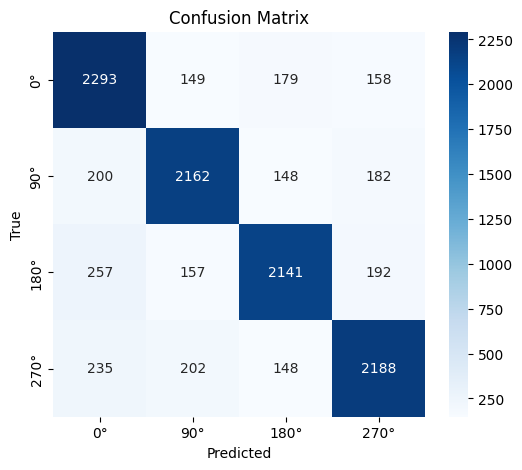


CLASSIFICATION REPORT
              precision    recall  f1-score   support

          0°     0.7682    0.8251    0.7956      2779
         90°     0.8097    0.8031    0.8064      2692
        180°     0.8184    0.7794    0.7984      2747
        270°     0.8044    0.7890    0.7967      2773

    accuracy                         0.7992     10991
   macro avg     0.8002    0.7992    0.7993     10991
weighted avg     0.8001    0.7992    0.7992     10991


ROC CURVES


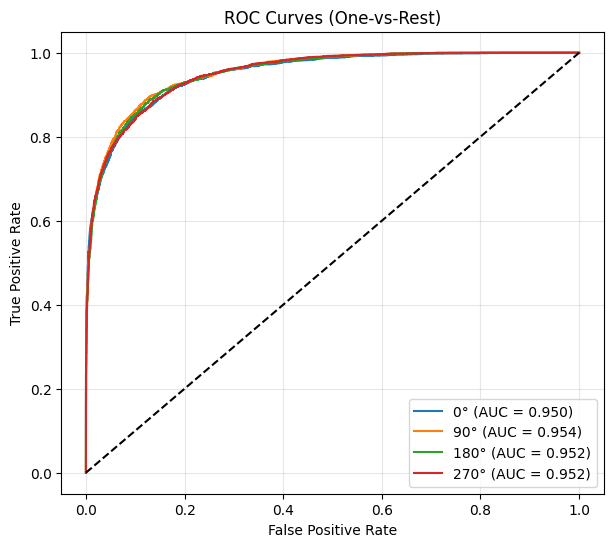


3. TOP CONFIDENT FAILURES (Visual Inspection)
These are images where the model was very confident but WRONG.


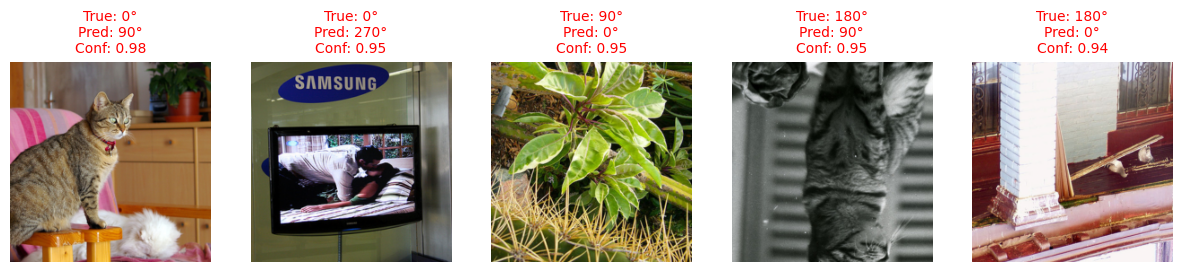

In [15]:
model = models.resnet50(weights=None)

num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(num_ftrs, num_ftrs),  # Hidden layer (maintains size or reduces)
    nn.ReLU(),                      
    nn.Linear(num_ftrs, 4)          
)

model.load_state_dict(torch.load("/kaggle/input/resnet50-fulltraining/pytorch/default/1/fullTraining_ResNet50.pth", map_location=device))
model.to(device)

evaluate_model(model, test_loader, class_names)

## ResNet50 fine-tuning


Test Accuracy: 0.8908


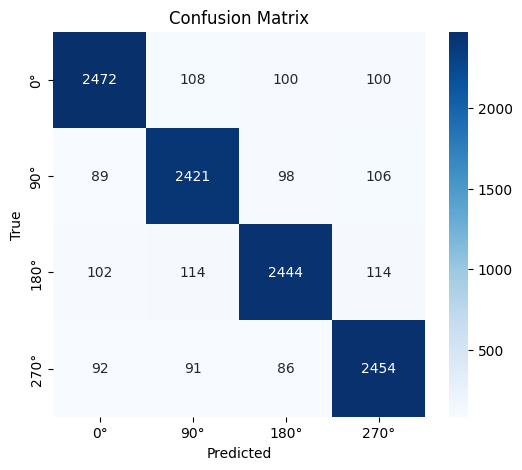


CLASSIFICATION REPORT
              precision    recall  f1-score   support

          0°     0.8973    0.8892    0.8932      2780
         90°     0.8855    0.8920    0.8888      2714
        180°     0.8959    0.8810    0.8884      2774
        270°     0.8846    0.9012    0.8929      2723

    accuracy                         0.8908     10991
   macro avg     0.8908    0.8909    0.8908     10991
weighted avg     0.8909    0.8908    0.8908     10991


ROC CURVES


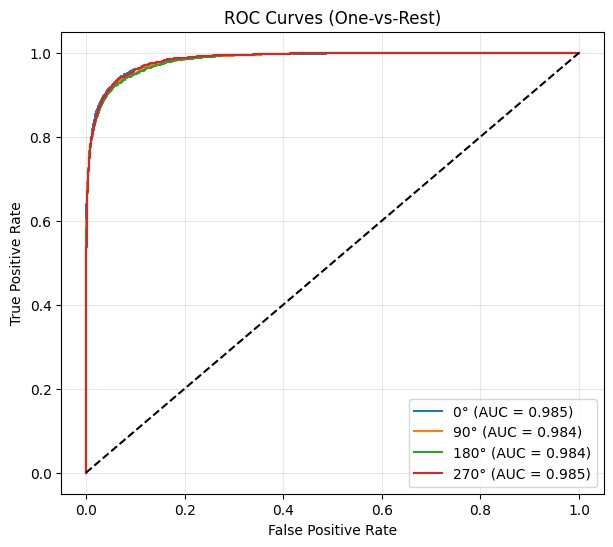


3. TOP CONFIDENT FAILURES (Visual Inspection)
These are images where the model was very confident but WRONG.


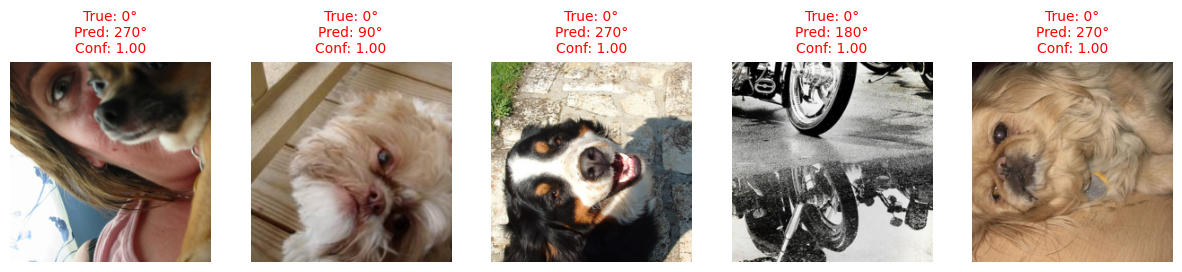

In [20]:
# Scarichiamo una ResNet50
model = models.resnet50(weights=None)

# Modifichiamo l'ultimo layer (Fully Connected) per avere 4 output (0, 90, 180, 270)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 4) 

model.load_state_dict(torch.load("/kaggle/input/resnet50-finetuning/pytorch/default/1/fineTuning_ResNet50.pth", map_location=device))
model.to(device)

evaluate_model(model, test_loader, class_names)

## Inception_V3 full training 

/usr/local/lib/python3.12/dist-packages/torchvision/models/inception.py:43: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(



Test Accuracy: 0.6726


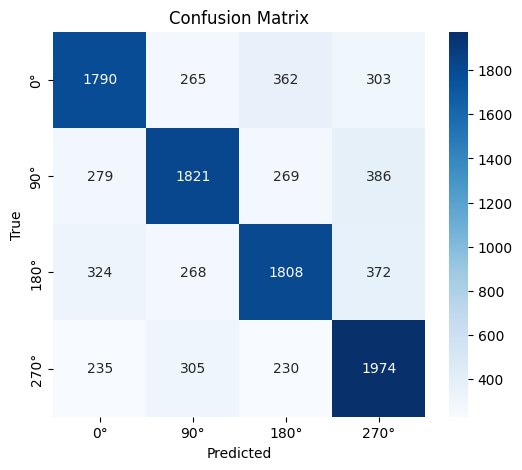


CLASSIFICATION REPORT
              precision    recall  f1-score   support

          0°     0.6811    0.6581    0.6694      2720
         90°     0.6848    0.6610    0.6727      2755
        180°     0.6774    0.6522    0.6646      2772
        270°     0.6504    0.7194    0.6832      2744

    accuracy                         0.6726     10991
   macro avg     0.6734    0.6727    0.6725     10991
weighted avg     0.6735    0.6726    0.6725     10991


ROC CURVES


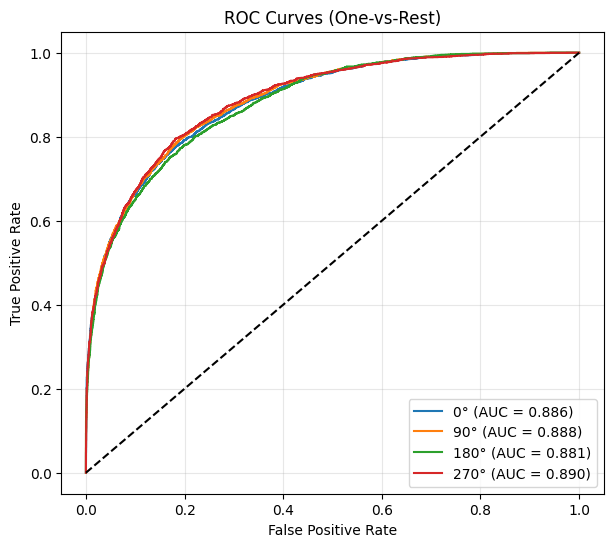


3. TOP CONFIDENT FAILURES (Visual Inspection)
These are images where the model was very confident but WRONG.


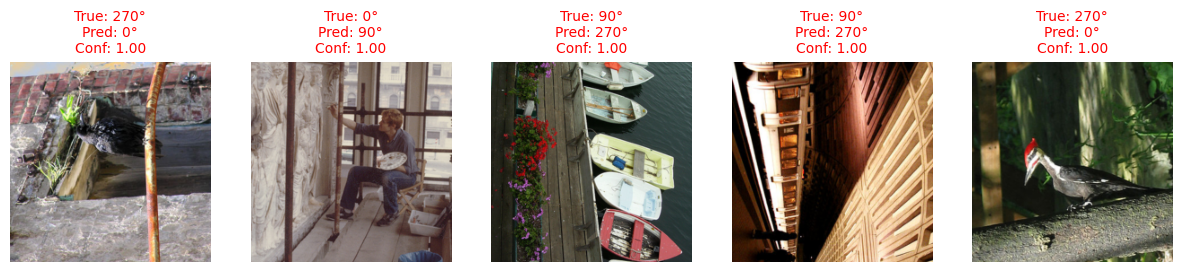

In [40]:
model = models.inception_v3(weights=None, aux_logits=False)

# Handle the primary net
model.fc = nn.Linear(model.fc.in_features, 4)
# Handle the auxilary net
# model.AuxLogits.fc = nn.Linear(model.AuxLogits.fc.in_features, 4)

model.load_state_dict(torch.load("/kaggle/input/inceptionv3-fulltraining-nocrop/pytorch/default/1/fullTraining_InceptionV3_nocropmix.pth", map_location=device), strict=False)
model.to(device)

evaluate_model(model, test_loader, class_names)

## Inception_V3 full training with CropMix

/usr/local/lib/python3.12/dist-packages/torchvision/models/inception.py:43: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(



Test Accuracy: 0.7524


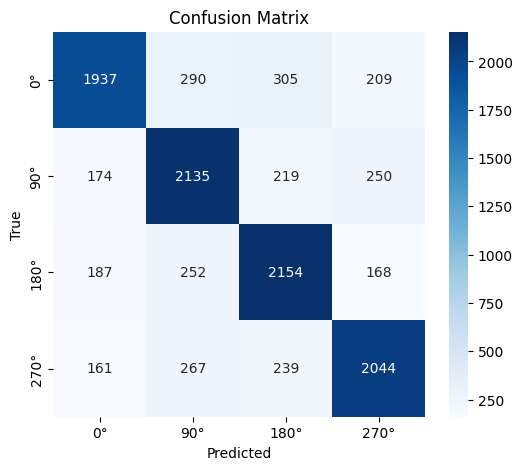


CLASSIFICATION REPORT
              precision    recall  f1-score   support

          0°     0.7877    0.7067    0.7450      2741
         90°     0.7252    0.7685    0.7462      2778
        180°     0.7384    0.7802    0.7587      2761
        270°     0.7653    0.7540    0.7596      2711

    accuracy                         0.7524     10991
   macro avg     0.7542    0.7523    0.7524     10991
weighted avg     0.7540    0.7524    0.7524     10991


ROC CURVES


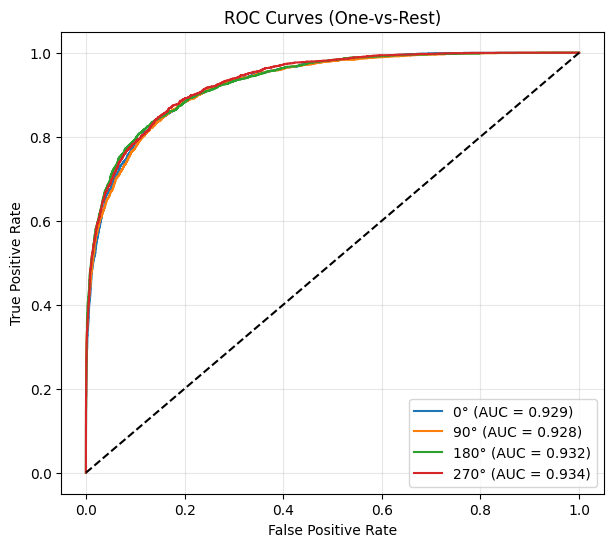


3. TOP CONFIDENT FAILURES (Visual Inspection)
These are images where the model was very confident but WRONG.


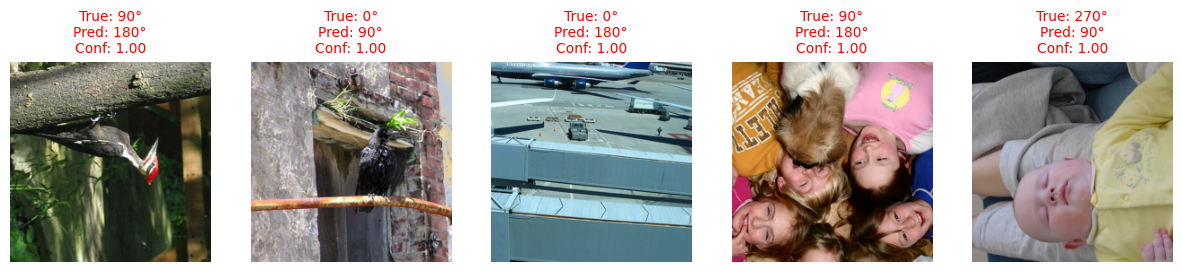

In [18]:
model = models.inception_v3(weights=None, aux_logits=False)
    
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(num_ftrs, num_ftrs),  # Hidden layer (maintains size or reduces)
    nn.ReLU(),                      # Non-linearity (Crucial!)
    nn.Linear(num_ftrs, 4)          # Output layer
)

model.load_state_dict(torch.load("/kaggle/input/inceptionv3-fulltraining/pytorch/default/1/fullTraining_InceptionV3.pth", map_location=device))
model.to(device)

evaluate_model(model, test_loader, class_names)

## Inception_V3 fine-tuning


Test Accuracy: 0.6973


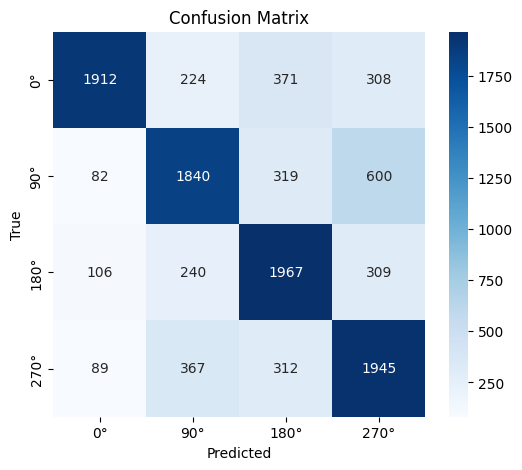


CLASSIFICATION REPORT
              precision    recall  f1-score   support

          0°     0.8735    0.6792    0.7642      2815
         90°     0.6889    0.6477    0.6676      2841
        180°     0.6625    0.7502    0.7036      2622
        270°     0.6151    0.7169    0.6621      2713

    accuracy                         0.6973     10991
   macro avg     0.7100    0.6985    0.6994     10991
weighted avg     0.7117    0.6973    0.6996     10991


ROC CURVES


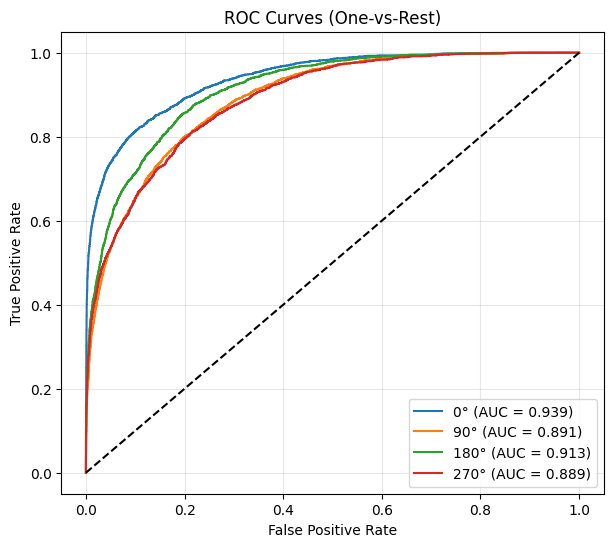


3. TOP CONFIDENT FAILURES (Visual Inspection)
These are images where the model was very confident but WRONG.


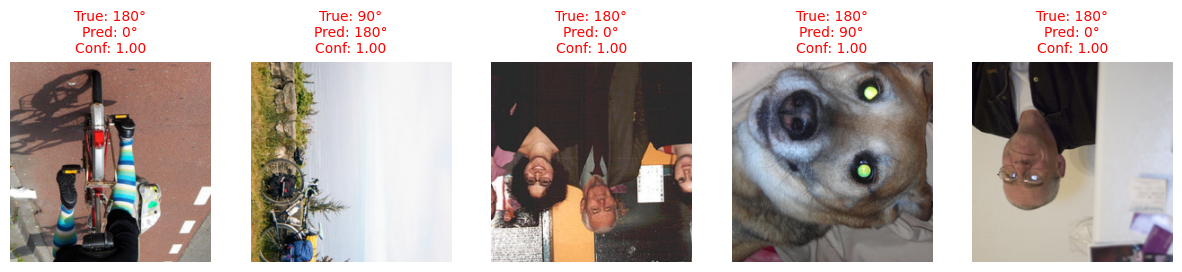

In [38]:
model = models.inception_v3(weights=None, aux_logits=False)

# Handle the primary net
model.fc = nn.Linear(model.fc.in_features, 4)
# Handle the auxilary net
# model.AuxLogits.fc = nn.Linear(model.AuxLogits.fc.in_features, 4)

model.load_state_dict(torch.load("/kaggle/input/inceptionv3-finetuning/pytorch/default/1/fineTuning_InceptionV3.pth", map_location=device), strict=False)
model.to(device)

evaluate_model(model, test_loader, class_names)

## EfficientNet_B0 full training


Test Accuracy: 0.8124


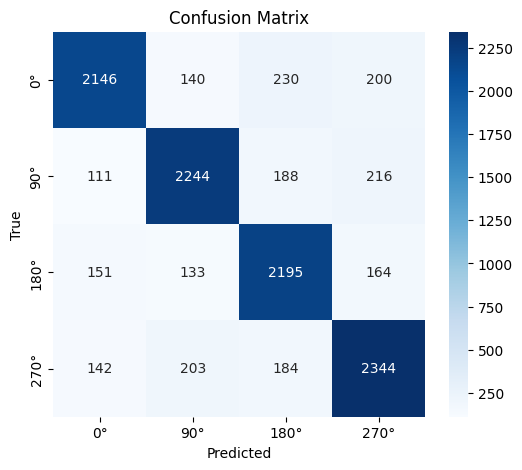


CLASSIFICATION REPORT
              precision    recall  f1-score   support

          0°     0.8416    0.7901    0.8150      2716
         90°     0.8250    0.8133    0.8191      2759
        180°     0.7848    0.8305    0.8070      2643
        270°     0.8016    0.8159    0.8087      2873

    accuracy                         0.8124     10991
   macro avg     0.8132    0.8125    0.8125     10991
weighted avg     0.8133    0.8124    0.8125     10991


ROC CURVES


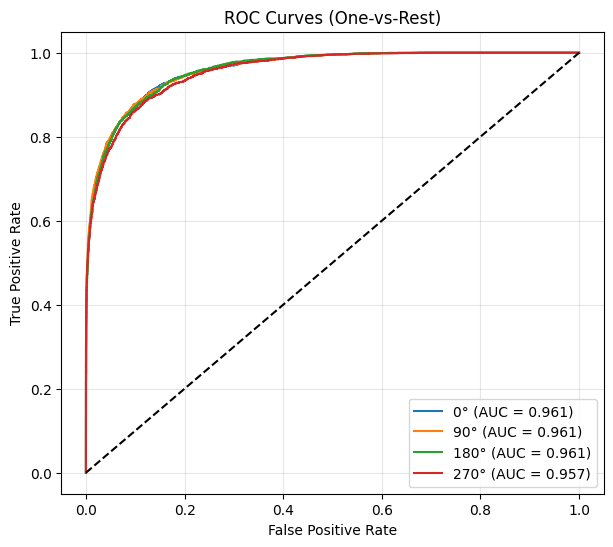


3. TOP CONFIDENT FAILURES (Visual Inspection)
These are images where the model was very confident but WRONG.


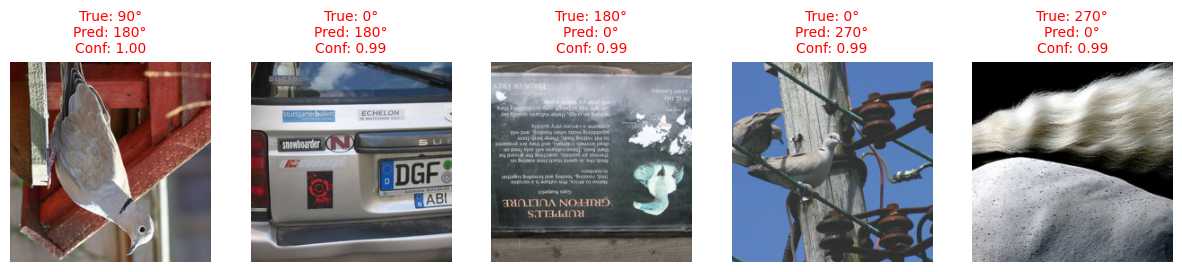

In [16]:
model = models.efficientnet_b0(weights = None)

# Modifichiamo l'ultimo layer (Fully Connected) per avere 4 output (0, 90, 180, 270)
num_ftrs = model.classifier[1].in_features

# 2. Definiamo la nuova sequenza
model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),    
    nn.Linear(num_ftrs, num_ftrs),      
    nn.ReLU(),                          
    nn.Linear(num_ftrs, 4) 
)

model.load_state_dict(torch.load("/kaggle/input/efficientnetb0-fulltraining-nocrop/pytorch/default/1/fullTraining_EfficientNetB0_nocropmix.pth", map_location=device))
model.to(device)

evaluate_model(model, test_loader, class_names)

## EfficientNet_B0 full training with CropMix

In [21]:
model = models.efficientnet_b0(weights = None)

# Modifichiamo l'ultimo layer (Fully Connected) per avere 4 output (0, 90, 180, 270)
num_ftrs = model.classifier[1].in_features

# 2. Definiamo la nuova sequenza
model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),    
    nn.Linear(num_ftrs, num_ftrs),      
    nn.ReLU(),                          
    nn.Linear(num_ftrs, 4) 
)
model.load_state_dict(torch.load("/kaggle/input/efficientnetb0-fulltraining/pytorch/default/1/fullTraining_EfficientNetB0.pth", map_location=device))
model.to(device)

evaluate_model(model, test_loader, class_names)

RuntimeError: Error(s) in loading state_dict for EfficientNet:
	Missing key(s) in state_dict: "features.0.0.weight", "features.0.1.weight", "features.0.1.bias", "features.0.1.running_mean", "features.0.1.running_var", "features.1.0.block.0.0.weight", "features.1.0.block.0.1.weight", "features.1.0.block.0.1.bias", "features.1.0.block.0.1.running_mean", "features.1.0.block.0.1.running_var", "features.1.0.block.1.fc1.weight", "features.1.0.block.1.fc1.bias", "features.1.0.block.1.fc2.weight", "features.1.0.block.1.fc2.bias", "features.1.0.block.2.0.weight", "features.1.0.block.2.1.weight", "features.1.0.block.2.1.bias", "features.1.0.block.2.1.running_mean", "features.1.0.block.2.1.running_var", "features.2.0.block.0.0.weight", "features.2.0.block.0.1.weight", "features.2.0.block.0.1.bias", "features.2.0.block.0.1.running_mean", "features.2.0.block.0.1.running_var", "features.2.0.block.1.0.weight", "features.2.0.block.1.1.weight", "features.2.0.block.1.1.bias", "features.2.0.block.1.1.running_mean", "features.2.0.block.1.1.running_var", "features.2.0.block.2.fc1.weight", "features.2.0.block.2.fc1.bias", "features.2.0.block.2.fc2.weight", "features.2.0.block.2.fc2.bias", "features.2.0.block.3.0.weight", "features.2.0.block.3.1.weight", "features.2.0.block.3.1.bias", "features.2.0.block.3.1.running_mean", "features.2.0.block.3.1.running_var", "features.2.1.block.0.0.weight", "features.2.1.block.0.1.weight", "features.2.1.block.0.1.bias", "features.2.1.block.0.1.running_mean", "features.2.1.block.0.1.running_var", "features.2.1.block.1.0.weight", "features.2.1.block.1.1.weight", "features.2.1.block.1.1.bias", "features.2.1.block.1.1.running_mean", "features.2.1.block.1.1.running_var", "features.2.1.block.2.fc1.weight", "features.2.1.block.2.fc1.bias", "features.2.1.block.2.fc2.weight", "features.2.1.block.2.fc2.bias", "features.2.1.block.3.0.weight", "features.2.1.block.3.1.weight", "features.2.1.block.3.1.bias", "features.2.1.block.3.1.running_mean", "features.2.1.block.3.1.running_var", "features.3.0.block.0.0.weight", "features.3.0.block.0.1.weight", "features.3.0.block.0.1.bias", "features.3.0.block.0.1.running_mean", "features.3.0.block.0.1.running_var", "features.3.0.block.1.0.weight", "features.3.0.block.1.1.weight", "features.3.0.block.1.1.bias", "features.3.0.block.1.1.running_mean", "features.3.0.block.1.1.running_var", "features.3.0.block.2.fc1.weight", "features.3.0.block.2.fc1.bias", "features.3.0.block.2.fc2.weight", "features.3.0.block.2.fc2.bias", "features.3.0.block.3.0.weight", "features.3.0.block.3.1.weight", "features.3.0.block.3.1.bias", "features.3.0.block.3.1.running_mean", "features.3.0.block.3.1.running_var", "features.3.1.block.0.0.weight", "features.3.1.block.0.1.weight", "features.3.1.block.0.1.bias", "features.3.1.block.0.1.running_mean", "features.3.1.block.0.1.running_var", "features.3.1.block.1.0.weight", "features.3.1.block.1.1.weight", "features.3.1.block.1.1.bias", "features.3.1.block.1.1.running_mean", "features.3.1.block.1.1.running_var", "features.3.1.block.2.fc1.weight", "features.3.1.block.2.fc1.bias", "features.3.1.block.2.fc2.weight", "features.3.1.block.2.fc2.bias", "features.3.1.block.3.0.weight", "features.3.1.block.3.1.weight", "features.3.1.block.3.1.bias", "features.3.1.block.3.1.running_mean", "features.3.1.block.3.1.running_var", "features.4.0.block.0.0.weight", "features.4.0.block.0.1.weight", "features.4.0.block.0.1.bias", "features.4.0.block.0.1.running_mean", "features.4.0.block.0.1.running_var", "features.4.0.block.1.0.weight", "features.4.0.block.1.1.weight", "features.4.0.block.1.1.bias", "features.4.0.block.1.1.running_mean", "features.4.0.block.1.1.running_var", "features.4.0.block.2.fc1.weight", "features.4.0.block.2.fc1.bias", "features.4.0.block.2.fc2.weight", "features.4.0.block.2.fc2.bias", "features.4.0.block.3.0.weight", "features.4.0.block.3.1.weight", "features.4.0.block.3.1.bias", "features.4.0.block.3.1.running_mean", "features.4.0.block.3.1.running_var", "features.4.1.block.0.0.weight", "features.4.1.block.0.1.weight", "features.4.1.block.0.1.bias", "features.4.1.block.0.1.running_mean", "features.4.1.block.0.1.running_var", "features.4.1.block.1.0.weight", "features.4.1.block.1.1.weight", "features.4.1.block.1.1.bias", "features.4.1.block.1.1.running_mean", "features.4.1.block.1.1.running_var", "features.4.1.block.2.fc1.weight", "features.4.1.block.2.fc1.bias", "features.4.1.block.2.fc2.weight", "features.4.1.block.2.fc2.bias", "features.4.1.block.3.0.weight", "features.4.1.block.3.1.weight", "features.4.1.block.3.1.bias", "features.4.1.block.3.1.running_mean", "features.4.1.block.3.1.running_var", "features.4.2.block.0.0.weight", "features.4.2.block.0.1.weight", "features.4.2.block.0.1.bias", "features.4.2.block.0.1.running_mean", "features.4.2.block.0.1.running_var", "features.4.2.block.1.0.weight", "features.4.2.block.1.1.weight", "features.4.2.block.1.1.bias", "features.4.2.block.1.1.running_mean", "features.4.2.block.1.1.running_var", "features.4.2.block.2.fc1.weight", "features.4.2.block.2.fc1.bias", "features.4.2.block.2.fc2.weight", "features.4.2.block.2.fc2.bias", "features.4.2.block.3.0.weight", "features.4.2.block.3.1.weight", "features.4.2.block.3.1.bias", "features.4.2.block.3.1.running_mean", "features.4.2.block.3.1.running_var", "features.5.0.block.0.0.weight", "features.5.0.block.0.1.weight", "features.5.0.block.0.1.bias", "features.5.0.block.0.1.running_mean", "features.5.0.block.0.1.running_var", "features.5.0.block.1.0.weight", "features.5.0.block.1.1.weight", "features.5.0.block.1.1.bias", "features.5.0.block.1.1.running_mean", "features.5.0.block.1.1.running_var", "features.5.0.block.2.fc1.weight", "features.5.0.block.2.fc1.bias", "features.5.0.block.2.fc2.weight", "features.5.0.block.2.fc2.bias", "features.5.0.block.3.0.weight", "features.5.0.block.3.1.weight", "features.5.0.block.3.1.bias", "features.5.0.block.3.1.running_mean", "features.5.0.block.3.1.running_var", "features.5.1.block.0.0.weight", "features.5.1.block.0.1.weight", "features.5.1.block.0.1.bias", "features.5.1.block.0.1.running_mean", "features.5.1.block.0.1.running_var", "features.5.1.block.1.0.weight", "features.5.1.block.1.1.weight", "features.5.1.block.1.1.bias", "features.5.1.block.1.1.running_mean", "features.5.1.block.1.1.running_var", "features.5.1.block.2.fc1.weight", "features.5.1.block.2.fc1.bias", "features.5.1.block.2.fc2.weight", "features.5.1.block.2.fc2.bias", "features.5.1.block.3.0.weight", "features.5.1.block.3.1.weight", "features.5.1.block.3.1.bias", "features.5.1.block.3.1.running_mean", "features.5.1.block.3.1.running_var", "features.5.2.block.0.0.weight", "features.5.2.block.0.1.weight", "features.5.2.block.0.1.bias", "features.5.2.block.0.1.running_mean", "features.5.2.block.0.1.running_var", "features.5.2.block.1.0.weight", "features.5.2.block.1.1.weight", "features.5.2.block.1.1.bias", "features.5.2.block.1.1.running_mean", "features.5.2.block.1.1.running_var", "features.5.2.block.2.fc1.weight", "features.5.2.block.2.fc1.bias", "features.5.2.block.2.fc2.weight", "features.5.2.block.2.fc2.bias", "features.5.2.block.3.0.weight", "features.5.2.block.3.1.weight", "features.5.2.block.3.1.bias", "features.5.2.block.3.1.running_mean", "features.5.2.block.3.1.running_var", "features.6.0.block.0.0.weight", "features.6.0.block.0.1.weight", "features.6.0.block.0.1.bias", "features.6.0.block.0.1.running_mean", "features.6.0.block.0.1.running_var", "features.6.0.block.1.0.weight", "features.6.0.block.1.1.weight", "features.6.0.block.1.1.bias", "features.6.0.block.1.1.running_mean", "features.6.0.block.1.1.running_var", "features.6.0.block.2.fc1.weight", "features.6.0.block.2.fc1.bias", "features.6.0.block.2.fc2.weight", "features.6.0.block.2.fc2.bias", "features.6.0.block.3.0.weight", "features.6.0.block.3.1.weight", "features.6.0.block.3.1.bias", "features.6.0.block.3.1.running_mean", "features.6.0.block.3.1.running_var", "features.6.1.block.0.0.weight", "features.6.1.block.0.1.weight", "features.6.1.block.0.1.bias", "features.6.1.block.0.1.running_mean", "features.6.1.block.0.1.running_var", "features.6.1.block.1.0.weight", "features.6.1.block.1.1.weight", "features.6.1.block.1.1.bias", "features.6.1.block.1.1.running_mean", "features.6.1.block.1.1.running_var", "features.6.1.block.2.fc1.weight", "features.6.1.block.2.fc1.bias", "features.6.1.block.2.fc2.weight", "features.6.1.block.2.fc2.bias", "features.6.1.block.3.0.weight", "features.6.1.block.3.1.weight", "features.6.1.block.3.1.bias", "features.6.1.block.3.1.running_mean", "features.6.1.block.3.1.running_var", "features.6.2.block.0.0.weight", "features.6.2.block.0.1.weight", "features.6.2.block.0.1.bias", "features.6.2.block.0.1.running_mean", "features.6.2.block.0.1.running_var", "features.6.2.block.1.0.weight", "features.6.2.block.1.1.weight", "features.6.2.block.1.1.bias", "features.6.2.block.1.1.running_mean", "features.6.2.block.1.1.running_var", "features.6.2.block.2.fc1.weight", "features.6.2.block.2.fc1.bias", "features.6.2.block.2.fc2.weight", "features.6.2.block.2.fc2.bias", "features.6.2.block.3.0.weight", "features.6.2.block.3.1.weight", "features.6.2.block.3.1.bias", "features.6.2.block.3.1.running_mean", "features.6.2.block.3.1.running_var", "features.6.3.block.0.0.weight", "features.6.3.block.0.1.weight", "features.6.3.block.0.1.bias", "features.6.3.block.0.1.running_mean", "features.6.3.block.0.1.running_var", "features.6.3.block.1.0.weight", "features.6.3.block.1.1.weight", "features.6.3.block.1.1.bias", "features.6.3.block.1.1.running_mean", "features.6.3.block.1.1.running_var", "features.6.3.block.2.fc1.weight", "features.6.3.block.2.fc1.bias", "features.6.3.block.2.fc2.weight", "features.6.3.block.2.fc2.bias", "features.6.3.block.3.0.weight", "features.6.3.block.3.1.weight", "features.6.3.block.3.1.bias", "features.6.3.block.3.1.running_mean", "features.6.3.block.3.1.running_var", "features.7.0.block.0.0.weight", "features.7.0.block.0.1.weight", "features.7.0.block.0.1.bias", "features.7.0.block.0.1.running_mean", "features.7.0.block.0.1.running_var", "features.7.0.block.1.0.weight", "features.7.0.block.1.1.weight", "features.7.0.block.1.1.bias", "features.7.0.block.1.1.running_mean", "features.7.0.block.1.1.running_var", "features.7.0.block.2.fc1.weight", "features.7.0.block.2.fc1.bias", "features.7.0.block.2.fc2.weight", "features.7.0.block.2.fc2.bias", "features.7.0.block.3.0.weight", "features.7.0.block.3.1.weight", "features.7.0.block.3.1.bias", "features.7.0.block.3.1.running_mean", "features.7.0.block.3.1.running_var", "features.8.0.weight", "features.8.1.weight", "features.8.1.bias", "features.8.1.running_mean", "features.8.1.running_var", "classifier.1.weight", "classifier.1.bias", "classifier.3.weight", "classifier.3.bias". 
	Unexpected key(s) in state_dict: "module.features.0.0.weight", "module.features.0.1.weight", "module.features.0.1.bias", "module.features.0.1.running_mean", "module.features.0.1.running_var", "module.features.0.1.num_batches_tracked", "module.features.1.0.block.0.0.weight", "module.features.1.0.block.0.1.weight", "module.features.1.0.block.0.1.bias", "module.features.1.0.block.0.1.running_mean", "module.features.1.0.block.0.1.running_var", "module.features.1.0.block.0.1.num_batches_tracked", "module.features.1.0.block.1.fc1.weight", "module.features.1.0.block.1.fc1.bias", "module.features.1.0.block.1.fc2.weight", "module.features.1.0.block.1.fc2.bias", "module.features.1.0.block.2.0.weight", "module.features.1.0.block.2.1.weight", "module.features.1.0.block.2.1.bias", "module.features.1.0.block.2.1.running_mean", "module.features.1.0.block.2.1.running_var", "module.features.1.0.block.2.1.num_batches_tracked", "module.features.2.0.block.0.0.weight", "module.features.2.0.block.0.1.weight", "module.features.2.0.block.0.1.bias", "module.features.2.0.block.0.1.running_mean", "module.features.2.0.block.0.1.running_var", "module.features.2.0.block.0.1.num_batches_tracked", "module.features.2.0.block.1.0.weight", "module.features.2.0.block.1.1.weight", "module.features.2.0.block.1.1.bias", "module.features.2.0.block.1.1.running_mean", "module.features.2.0.block.1.1.running_var", "module.features.2.0.block.1.1.num_batches_tracked", "module.features.2.0.block.2.fc1.weight", "module.features.2.0.block.2.fc1.bias", "module.features.2.0.block.2.fc2.weight", "module.features.2.0.block.2.fc2.bias", "module.features.2.0.block.3.0.weight", "module.features.2.0.block.3.1.weight", "module.features.2.0.block.3.1.bias", "module.features.2.0.block.3.1.running_mean", "module.features.2.0.block.3.1.running_var", "module.features.2.0.block.3.1.num_batches_tracked", "module.features.2.1.block.0.0.weight", "module.features.2.1.block.0.1.weight", "module.features.2.1.block.0.1.bias", "module.features.2.1.block.0.1.running_mean", "module.features.2.1.block.0.1.running_var", "module.features.2.1.block.0.1.num_batches_tracked", "module.features.2.1.block.1.0.weight", "module.features.2.1.block.1.1.weight", "module.features.2.1.block.1.1.bias", "module.features.2.1.block.1.1.running_mean", "module.features.2.1.block.1.1.running_var", "module.features.2.1.block.1.1.num_batches_tracked", "module.features.2.1.block.2.fc1.weight", "module.features.2.1.block.2.fc1.bias", "module.features.2.1.block.2.fc2.weight", "module.features.2.1.block.2.fc2.bias", "module.features.2.1.block.3.0.weight", "module.features.2.1.block.3.1.weight", "module.features.2.1.block.3.1.bias", "module.features.2.1.block.3.1.running_mean", "module.features.2.1.block.3.1.running_var", "module.features.2.1.block.3.1.num_batches_tracked", "module.features.3.0.block.0.0.weight", "module.features.3.0.block.0.1.weight", "module.features.3.0.block.0.1.bias", "module.features.3.0.block.0.1.running_mean", "module.features.3.0.block.0.1.running_var", "module.features.3.0.block.0.1.num_batches_tracked", "module.features.3.0.block.1.0.weight", "module.features.3.0.block.1.1.weight", "module.features.3.0.block.1.1.bias", "module.features.3.0.block.1.1.running_mean", "module.features.3.0.block.1.1.running_var", "module.features.3.0.block.1.1.num_batches_tracked", "module.features.3.0.block.2.fc1.weight", "module.features.3.0.block.2.fc1.bias", "module.features.3.0.block.2.fc2.weight", "module.features.3.0.block.2.fc2.bias", "module.features.3.0.block.3.0.weight", "module.features.3.0.block.3.1.weight", "module.features.3.0.block.3.1.bias", "module.features.3.0.block.3.1.running_mean", "module.features.3.0.block.3.1.running_var", "module.features.3.0.block.3.1.num_batches_tracked", "module.features.3.1.block.0.0.weight", "module.features.3.1.block.0.1.weight", "module.features.3.1.block.0.1.bias", "module.features.3.1.block.0.1.running_mean", "module.features.3.1.block.0.1.running_var", "module.features.3.1.block.0.1.num_batches_tracked", "module.features.3.1.block.1.0.weight", "module.features.3.1.block.1.1.weight", "module.features.3.1.block.1.1.bias", "module.features.3.1.block.1.1.running_mean", "module.features.3.1.block.1.1.running_var", "module.features.3.1.block.1.1.num_batches_tracked", "module.features.3.1.block.2.fc1.weight", "module.features.3.1.block.2.fc1.bias", "module.features.3.1.block.2.fc2.weight", "module.features.3.1.block.2.fc2.bias", "module.features.3.1.block.3.0.weight", "module.features.3.1.block.3.1.weight", "module.features.3.1.block.3.1.bias", "module.features.3.1.block.3.1.running_mean", "module.features.3.1.block.3.1.running_var", "module.features.3.1.block.3.1.num_batches_tracked", "module.features.4.0.block.0.0.weight", "module.features.4.0.block.0.1.weight", "module.features.4.0.block.0.1.bias", "module.features.4.0.block.0.1.running_mean", "module.features.4.0.block.0.1.running_var", "module.features.4.0.block.0.1.num_batches_tracked", "module.features.4.0.block.1.0.weight", "module.features.4.0.block.1.1.weight", "module.features.4.0.block.1.1.bias", "module.features.4.0.block.1.1.running_mean", "module.features.4.0.block.1.1.running_var", "module.features.4.0.block.1.1.num_batches_tracked", "module.features.4.0.block.2.fc1.weight", "module.features.4.0.block.2.fc1.bias", "module.features.4.0.block.2.fc2.weight", "module.features.4.0.block.2.fc2.bias", "module.features.4.0.block.3.0.weight", "module.features.4.0.block.3.1.weight", "module.features.4.0.block.3.1.bias", "module.features.4.0.block.3.1.running_mean", "module.features.4.0.block.3.1.running_var", "module.features.4.0.block.3.1.num_batches_tracked", "module.features.4.1.block.0.0.weight", "module.features.4.1.block.0.1.weight", "module.features.4.1.block.0.1.bias", "module.features.4.1.block.0.1.running_mean", "module.features.4.1.block.0.1.running_var", "module.features.4.1.block.0.1.num_batches_tracked", "module.features.4.1.block.1.0.weight", "module.features.4.1.block.1.1.weight", "module.features.4.1.block.1.1.bias", "module.features.4.1.block.1.1.running_mean", "module.features.4.1.block.1.1.running_var", "module.features.4.1.block.1.1.num_batches_tracked", "module.features.4.1.block.2.fc1.weight", "module.features.4.1.block.2.fc1.bias", "module.features.4.1.block.2.fc2.weight", "module.features.4.1.block.2.fc2.bias", "module.features.4.1.block.3.0.weight", "module.features.4.1.block.3.1.weight", "module.features.4.1.block.3.1.bias", "module.features.4.1.block.3.1.running_mean", "module.features.4.1.block.3.1.running_var", "module.features.4.1.block.3.1.num_batches_tracked", "module.features.4.2.block.0.0.weight", "module.features.4.2.block.0.1.weight", "module.features.4.2.block.0.1.bias", "module.features.4.2.block.0.1.running_mean", "module.features.4.2.block.0.1.running_var", "module.features.4.2.block.0.1.num_batches_tracked", "module.features.4.2.block.1.0.weight", "module.features.4.2.block.1.1.weight", "module.features.4.2.block.1.1.bias", "module.features.4.2.block.1.1.running_mean", "module.features.4.2.block.1.1.running_var", "module.features.4.2.block.1.1.num_batches_tracked", "module.features.4.2.block.2.fc1.weight", "module.features.4.2.block.2.fc1.bias", "module.features.4.2.block.2.fc2.weight", "module.features.4.2.block.2.fc2.bias", "module.features.4.2.block.3.0.weight", "module.features.4.2.block.3.1.weight", "module.features.4.2.block.3.1.bias", "module.features.4.2.block.3.1.running_mean", "module.features.4.2.block.3.1.running_var", "module.features.4.2.block.3.1.num_batches_tracked", "module.features.5.0.block.0.0.weight", "module.features.5.0.block.0.1.weight", "module.features.5.0.block.0.1.bias", "module.features.5.0.block.0.1.running_mean", "module.features.5.0.block.0.1.running_var", "module.features.5.0.block.0.1.num_batches_tracked", "module.features.5.0.block.1.0.weight", "module.features.5.0.block.1.1.weight", "module.features.5.0.block.1.1.bias", "module.features.5.0.block.1.1.running_mean", "module.features.5.0.block.1.1.running_var", "module.features.5.0.block.1.1.num_batches_tracked", "module.features.5.0.block.2.fc1.weight", "module.features.5.0.block.2.fc1.bias", "module.features.5.0.block.2.fc2.weight", "module.features.5.0.block.2.fc2.bias", "module.features.5.0.block.3.0.weight", "module.features.5.0.block.3.1.weight", "module.features.5.0.block.3.1.bias", "module.features.5.0.block.3.1.running_mean", "module.features.5.0.block.3.1.running_var", "module.features.5.0.block.3.1.num_batches_tracked", "module.features.5.1.block.0.0.weight", "module.features.5.1.block.0.1.weight", "module.features.5.1.block.0.1.bias", "module.features.5.1.block.0.1.running_mean", "module.features.5.1.block.0.1.running_var", "module.features.5.1.block.0.1.num_batches_tracked", "module.features.5.1.block.1.0.weight", "module.features.5.1.block.1.1.weight", "module.features.5.1.block.1.1.bias", "module.features.5.1.block.1.1.running_mean", "module.features.5.1.block.1.1.running_var", "module.features.5.1.block.1.1.num_batches_tracked", "module.features.5.1.block.2.fc1.weight", "module.features.5.1.block.2.fc1.bias", "module.features.5.1.block.2.fc2.weight", "module.features.5.1.block.2.fc2.bias", "module.features.5.1.block.3.0.weight", "module.features.5.1.block.3.1.weight", "module.features.5.1.block.3.1.bias", "module.features.5.1.block.3.1.running_mean", "module.features.5.1.block.3.1.running_var", "module.features.5.1.block.3.1.num_batches_tracked", "module.features.5.2.block.0.0.weight", "module.features.5.2.block.0.1.weight", "module.features.5.2.block.0.1.bias", "module.features.5.2.block.0.1.running_mean", "module.features.5.2.block.0.1.running_var", "module.features.5.2.block.0.1.num_batches_tracked", "module.features.5.2.block.1.0.weight", "module.features.5.2.block.1.1.weight", "module.features.5.2.block.1.1.bias", "module.features.5.2.block.1.1.running_mean", "module.features.5.2.block.1.1.running_var", "module.features.5.2.block.1.1.num_batches_tracked", "module.features.5.2.block.2.fc1.weight", "module.features.5.2.block.2.fc1.bias", "module.features.5.2.block.2.fc2.weight", "module.features.5.2.block.2.fc2.bias", "module.features.5.2.block.3.0.weight", "module.features.5.2.block.3.1.weight", "module.features.5.2.block.3.1.bias", "module.features.5.2.block.3.1.running_mean", "module.features.5.2.block.3.1.running_var", "module.features.5.2.block.3.1.num_batches_tracked", "module.features.6.0.block.0.0.weight", "module.features.6.0.block.0.1.weight", "module.features.6.0.block.0.1.bias", "module.features.6.0.block.0.1.running_mean", "module.features.6.0.block.0.1.running_var", "module.features.6.0.block.0.1.num_batches_tracked", "module.features.6.0.block.1.0.weight", "module.features.6.0.block.1.1.weight", "module.features.6.0.block.1.1.bias", "module.features.6.0.block.1.1.running_mean", "module.features.6.0.block.1.1.running_var", "module.features.6.0.block.1.1.num_batches_tracked", "module.features.6.0.block.2.fc1.weight", "module.features.6.0.block.2.fc1.bias", "module.features.6.0.block.2.fc2.weight", "module.features.6.0.block.2.fc2.bias", "module.features.6.0.block.3.0.weight", "module.features.6.0.block.3.1.weight", "module.features.6.0.block.3.1.bias", "module.features.6.0.block.3.1.running_mean", "module.features.6.0.block.3.1.running_var", "module.features.6.0.block.3.1.num_batches_tracked", "module.features.6.1.block.0.0.weight", "module.features.6.1.block.0.1.weight", "module.features.6.1.block.0.1.bias", "module.features.6.1.block.0.1.running_mean", "module.features.6.1.block.0.1.running_var", "module.features.6.1.block.0.1.num_batches_tracked", "module.features.6.1.block.1.0.weight", "module.features.6.1.block.1.1.weight", "module.features.6.1.block.1.1.bias", "module.features.6.1.block.1.1.running_mean", "module.features.6.1.block.1.1.running_var", "module.features.6.1.block.1.1.num_batches_tracked", "module.features.6.1.block.2.fc1.weight", "module.features.6.1.block.2.fc1.bias", "module.features.6.1.block.2.fc2.weight", "module.features.6.1.block.2.fc2.bias", "module.features.6.1.block.3.0.weight", "module.features.6.1.block.3.1.weight", "module.features.6.1.block.3.1.bias", "module.features.6.1.block.3.1.running_mean", "module.features.6.1.block.3.1.running_var", "module.features.6.1.block.3.1.num_batches_tracked", "module.features.6.2.block.0.0.weight", "module.features.6.2.block.0.1.weight", "module.features.6.2.block.0.1.bias", "module.features.6.2.block.0.1.running_mean", "module.features.6.2.block.0.1.running_var", "module.features.6.2.block.0.1.num_batches_tracked", "module.features.6.2.block.1.0.weight", "module.features.6.2.block.1.1.weight", "module.features.6.2.block.1.1.bias", "module.features.6.2.block.1.1.running_mean", "module.features.6.2.block.1.1.running_var", "module.features.6.2.block.1.1.num_batches_tracked", "module.features.6.2.block.2.fc1.weight", "module.features.6.2.block.2.fc1.bias", "module.features.6.2.block.2.fc2.weight", "module.features.6.2.block.2.fc2.bias", "module.features.6.2.block.3.0.weight", "module.features.6.2.block.3.1.weight", "module.features.6.2.block.3.1.bias", "module.features.6.2.block.3.1.running_mean", "module.features.6.2.block.3.1.running_var", "module.features.6.2.block.3.1.num_batches_tracked", "module.features.6.3.block.0.0.weight", "module.features.6.3.block.0.1.weight", "module.features.6.3.block.0.1.bias", "module.features.6.3.block.0.1.running_mean", "module.features.6.3.block.0.1.running_var", "module.features.6.3.block.0.1.num_batches_tracked", "module.features.6.3.block.1.0.weight", "module.features.6.3.block.1.1.weight", "module.features.6.3.block.1.1.bias", "module.features.6.3.block.1.1.running_mean", "module.features.6.3.block.1.1.running_var", "module.features.6.3.block.1.1.num_batches_tracked", "module.features.6.3.block.2.fc1.weight", "module.features.6.3.block.2.fc1.bias", "module.features.6.3.block.2.fc2.weight", "module.features.6.3.block.2.fc2.bias", "module.features.6.3.block.3.0.weight", "module.features.6.3.block.3.1.weight", "module.features.6.3.block.3.1.bias", "module.features.6.3.block.3.1.running_mean", "module.features.6.3.block.3.1.running_var", "module.features.6.3.block.3.1.num_batches_tracked", "module.features.7.0.block.0.0.weight", "module.features.7.0.block.0.1.weight", "module.features.7.0.block.0.1.bias", "module.features.7.0.block.0.1.running_mean", "module.features.7.0.block.0.1.running_var", "module.features.7.0.block.0.1.num_batches_tracked", "module.features.7.0.block.1.0.weight", "module.features.7.0.block.1.1.weight", "module.features.7.0.block.1.1.bias", "module.features.7.0.block.1.1.running_mean", "module.features.7.0.block.1.1.running_var", "module.features.7.0.block.1.1.num_batches_tracked", "module.features.7.0.block.2.fc1.weight", "module.features.7.0.block.2.fc1.bias", "module.features.7.0.block.2.fc2.weight", "module.features.7.0.block.2.fc2.bias", "module.features.7.0.block.3.0.weight", "module.features.7.0.block.3.1.weight", "module.features.7.0.block.3.1.bias", "module.features.7.0.block.3.1.running_mean", "module.features.7.0.block.3.1.running_var", "module.features.7.0.block.3.1.num_batches_tracked", "module.features.8.0.weight", "module.features.8.1.weight", "module.features.8.1.bias", "module.features.8.1.running_mean", "module.features.8.1.running_var", "module.features.8.1.num_batches_tracked", "module.classifier.1.weight", "module.classifier.1.bias". 

## EfficientNet_B0 fine-tuning


Test Accuracy: 0.9139


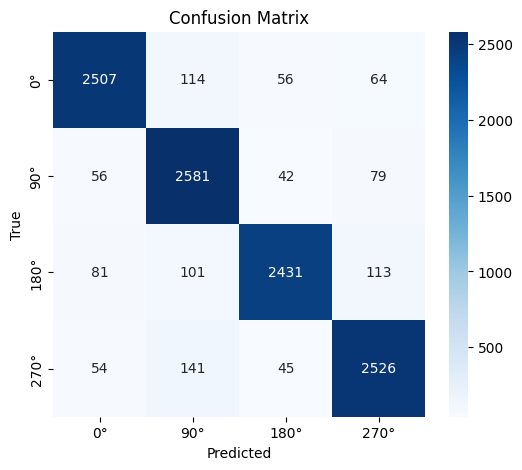


CLASSIFICATION REPORT
              precision    recall  f1-score   support

          0°     0.9292    0.9146    0.9219      2741
         90°     0.8788    0.9358    0.9064      2758
        180°     0.9444    0.8918    0.9174      2726
        270°     0.9080    0.9132    0.9106      2766

    accuracy                         0.9139     10991
   macro avg     0.9151    0.9139    0.9141     10991
weighted avg     0.9150    0.9139    0.9140     10991


ROC CURVES


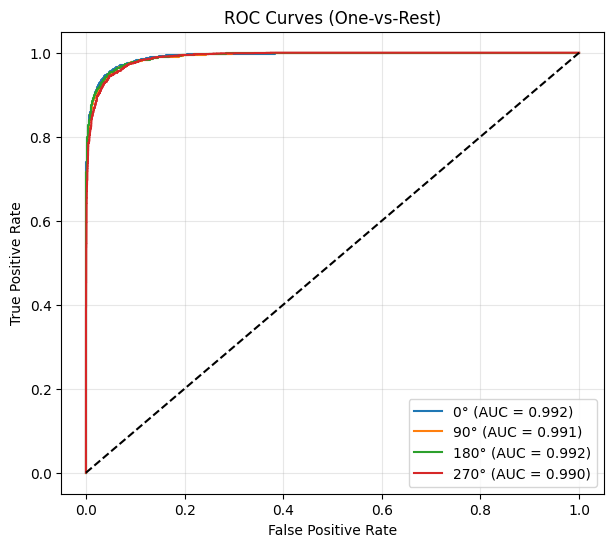


3. TOP CONFIDENT FAILURES (Visual Inspection)
These are images where the model was very confident but WRONG.


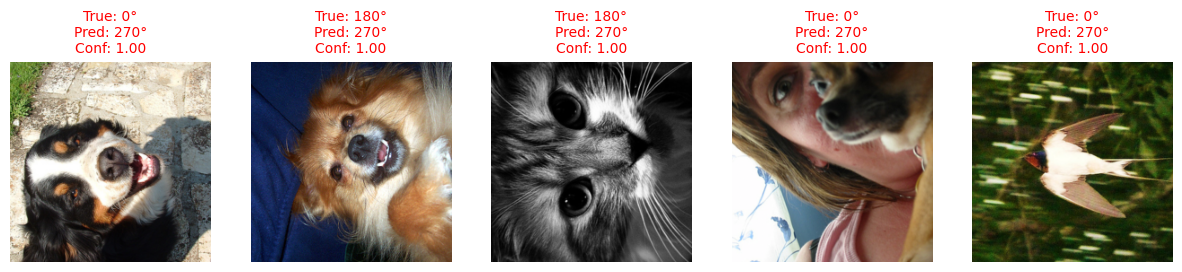

In [22]:
model = models.efficientnet_b0(weights=None)
    
num_ftrs = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_ftrs, 4)

model.load_state_dict(torch.load("/kaggle/input/efficientnetb0-finetuning/pytorch/default/1/fineTuning_EfficientNetB0.pth", map_location=device))
model.to(device)

evaluate_model(model, test_loader, class_names)

## EfficientNet_B3 full training


Test Accuracy: 0.8068


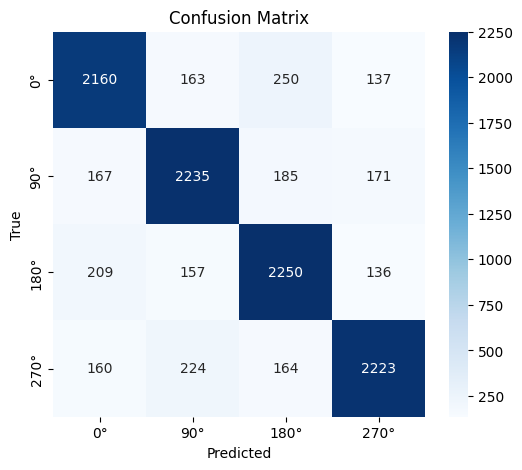


CLASSIFICATION REPORT
              precision    recall  f1-score   support

          0°     0.8012    0.7970    0.7991      2710
         90°     0.8042    0.8104    0.8073      2758
        180°     0.7898    0.8176    0.8034      2752
        270°     0.8335    0.8022    0.8176      2771

    accuracy                         0.8068     10991
   macro avg     0.8072    0.8068    0.8069     10991
weighted avg     0.8072    0.8068    0.8069     10991


ROC CURVES


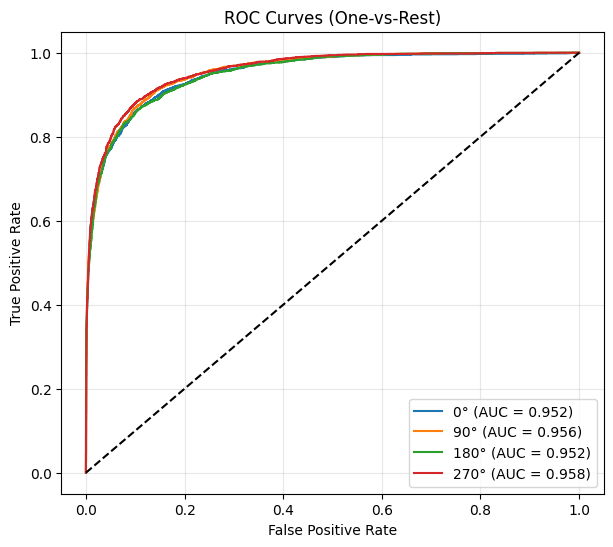


3. TOP CONFIDENT FAILURES (Visual Inspection)
These are images where the model was very confident but WRONG.


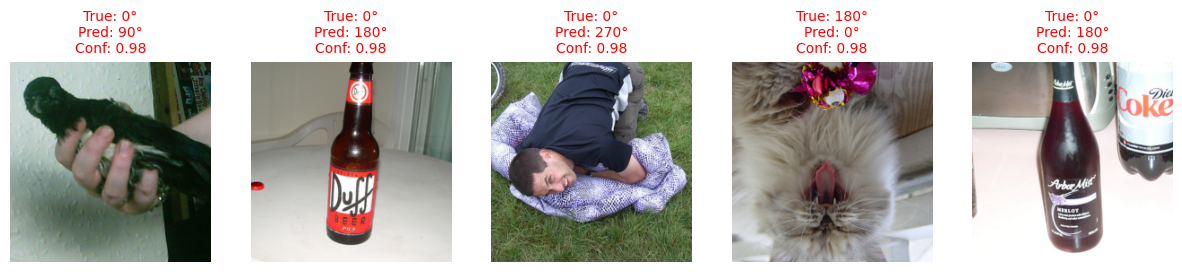

In [34]:
model = models.efficientnet_b3(weights=None)

num_ftrs = model.classifier[1].in_features
model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(num_ftrs, num_ftrs),  # hidden layer 1536 → 1536
    nn.ReLU(),
    nn.Linear(num_ftrs, 4)          # output layer
)

model.load_state_dict(torch.load("/kaggle/input/efficientnetb3-fulltraining-nocrop/pytorch/default/1/fullTraining_EfficientNetB3_nocropmix.pth", map_location=device))
model.to(device)

evaluate_model(model, test_loader, class_names)

## EfficientNet_B3 full training with CropMix


Test Accuracy: 0.6968


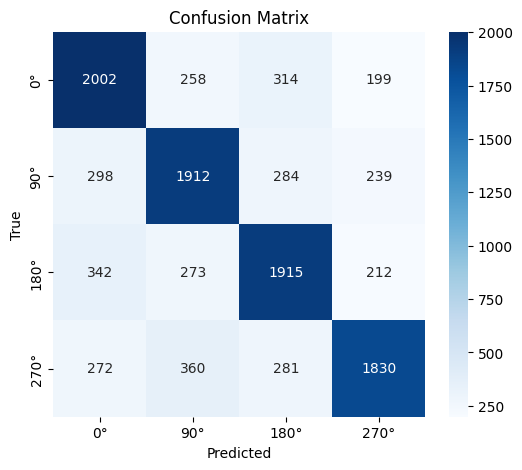


CLASSIFICATION REPORT
              precision    recall  f1-score   support

          0°     0.6870    0.7220    0.7041      2773
         90°     0.6821    0.6996    0.6908      2733
        180°     0.6854    0.6984    0.6918      2742
        270°     0.7379    0.6672    0.7007      2743

    accuracy                         0.6968     10991
   macro avg     0.6981    0.6968    0.6968     10991
weighted avg     0.6981    0.6968    0.6969     10991


ROC CURVES


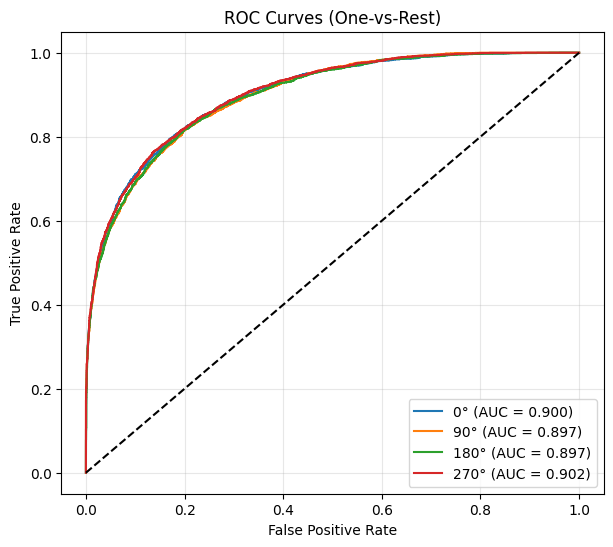


3. TOP CONFIDENT FAILURES (Visual Inspection)
These are images where the model was very confident but WRONG.


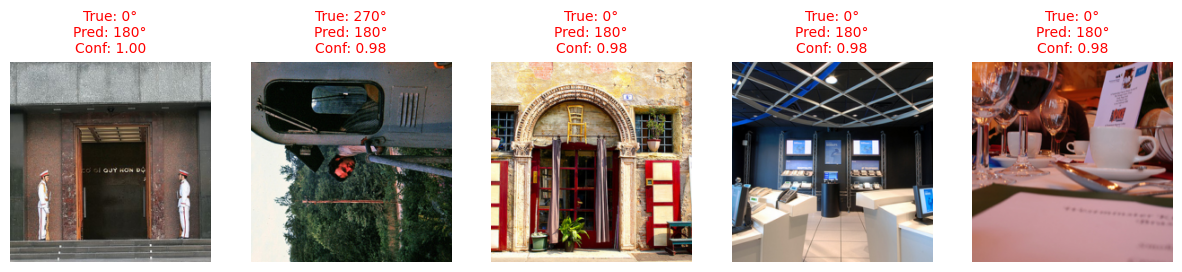

In [27]:
model = models.efficientnet_b3(weights = None)

# Modifichiamo l'ultimo layer (Fully Connected) per avere 4 output (0, 90, 180, 270)
num_ftrs = model.classifier[1].in_features

# 2. Definiamo la nuova sequenza
model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(num_ftrs, 4)
)

model.load_state_dict(torch.load("/kaggle/input/efficientnetb3-fulltraining/pytorch/default/1/fullTraining_EfficientNetB3.pth", map_location=device))
model.to(device)

evaluate_model(model, test_loader, class_names)

## EfficientNet_B3 fine-tuning


Test Accuracy: 0.9108


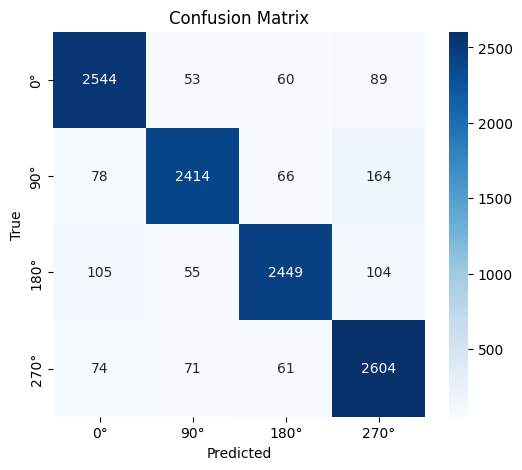


CLASSIFICATION REPORT
              precision    recall  f1-score   support

          0°     0.9082    0.9264    0.9173      2746
         90°     0.9310    0.8868    0.9084      2722
        180°     0.9291    0.9027    0.9157      2713
        270°     0.8794    0.9267    0.9024      2810

    accuracy                         0.9108     10991
   macro avg     0.9119    0.9107    0.9109     10991
weighted avg     0.9116    0.9108    0.9109     10991


ROC CURVES


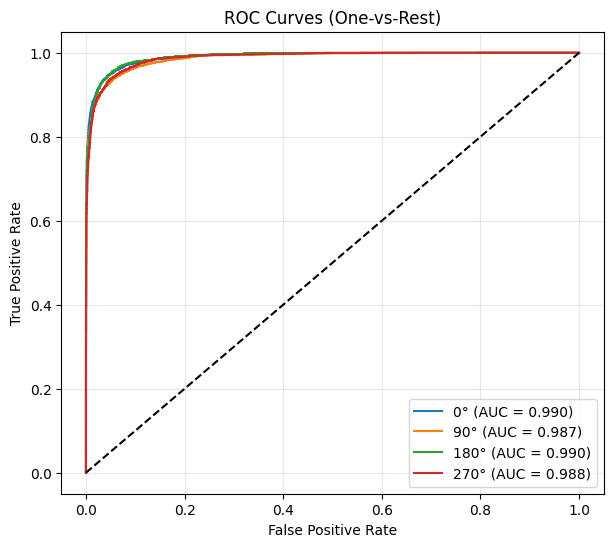


3. TOP CONFIDENT FAILURES (Visual Inspection)
These are images where the model was very confident but WRONG.


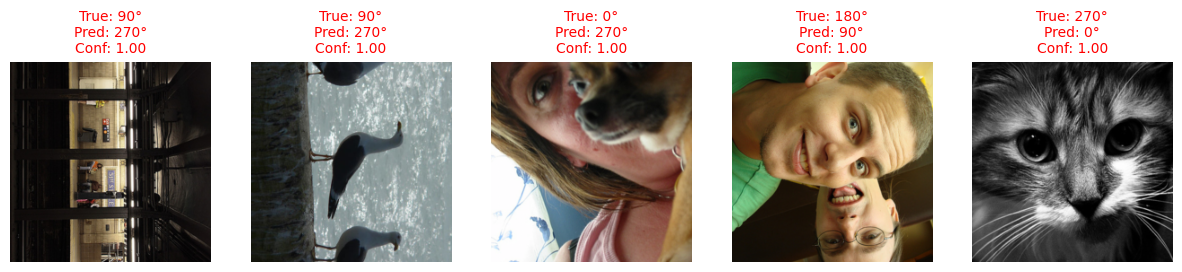

In [26]:
model = models.efficientnet_b3(weights=None)
    
num_ftrs = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_ftrs, 4)

model.load_state_dict(torch.load("/kaggle/input/efficientnetb3-finetuning/pytorch/default/1/fineTuning_EfficientNetB3.pth", map_location=device))
model.to(device)

evaluate_model(model, test_loader, class_names)